In [ ]:
!apt update
!apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,002 kB]
Hit:4 https://cli.github.com/packages stable InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [80.4 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,790 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates I

In [ ]:
# warning filters
import warnings
warnings.filterwarnings("ignore", message="Pandas requires version")
warnings.filterwarnings("ignore", message="A NumPy version >=")
warnings.filterwarnings("ignore", message="invalid value encountered in subtract")
warnings.filterwarnings("ignore", category=UserWarning, message="set_ticklabels\\(\\) should only be used with a fixed number of ticks")

import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


In [ ]:
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# dataset = "bod"
# extra = "Combo_5"

dataset = "folktables"
synth="aim"
extra = ""
df = pd.read_csv(f"results_{synth}_{dataset}{f'_{extra}' if extra else '_vldb'}.csv")

linestyle_tuple = [
     ('solid',                 (0, ())),
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 5))),
     ('densely dotted',        (0, (1, 1))),

     ('long dash with offset', (5, (10, 3))),
     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]


import re

def smart_capitalize(text):
    def cap_word(word):
        return word[0].upper() + word[1:] if word else ''

    # This will split and keep the delimiters (space, dash, underscore)
    parts = re.split(r'([ _-])', text)
    return ''.join(cap_word(part) if part not in ' _-' else part for part in parts)


def categorize_method(epsilon, fair_method, dp_method) -> str:
    """
    Build a category label based on DP and fairness usage.

    - If `epsilon` is non-empty ⇒ DP was used ⇒ prefix 'DP', else 'NoDP'
    - If `fair_method` is 'reweigh' ⇒ code 'RW', empty ⇒ '', else use method name
    Returns a string like 'DP_Fair[RW]' or 'Fair[RW]' or 'Baseline'
    """

    # Check for real epsilon (DP) and non-empty fair_method
    has_dp = pd.notnull(epsilon)
    has_fair = pd.notnull(fair_method) and str(fair_method).strip() != ''

    # Baseline if no DP and no fairness
    if not has_dp and not has_fair:
        return 'Baseline'

    # DP prefix
    dp_prefix = 'DP_' if has_dp else ''

    # Fairness code
    fair_code = ''
    if has_fair:
        fm = str(fair_method).strip().lower()
        if fm == 'reweigh':
            fair_code = 'RW'
        elif fm == 'eqodds':
            fair_code = 'EqOdds'
        else:
            fair_code = fm.upper()

    # Compose category
    if fair_code:
        return f"{dp_prefix}Fair[{fair_code}]"
    else:
        return "DP"

df["method"] = df.apply(
    lambda row: categorize_method(row['Epsilon'], row['Fair-Method'], row['DP-Method']),
    axis=1
)
df["eps"] = df["Epsilon"]
df_filtered = df[df["method"].notnull()]
linestyles = [spec for _, spec in linestyle_tuple]

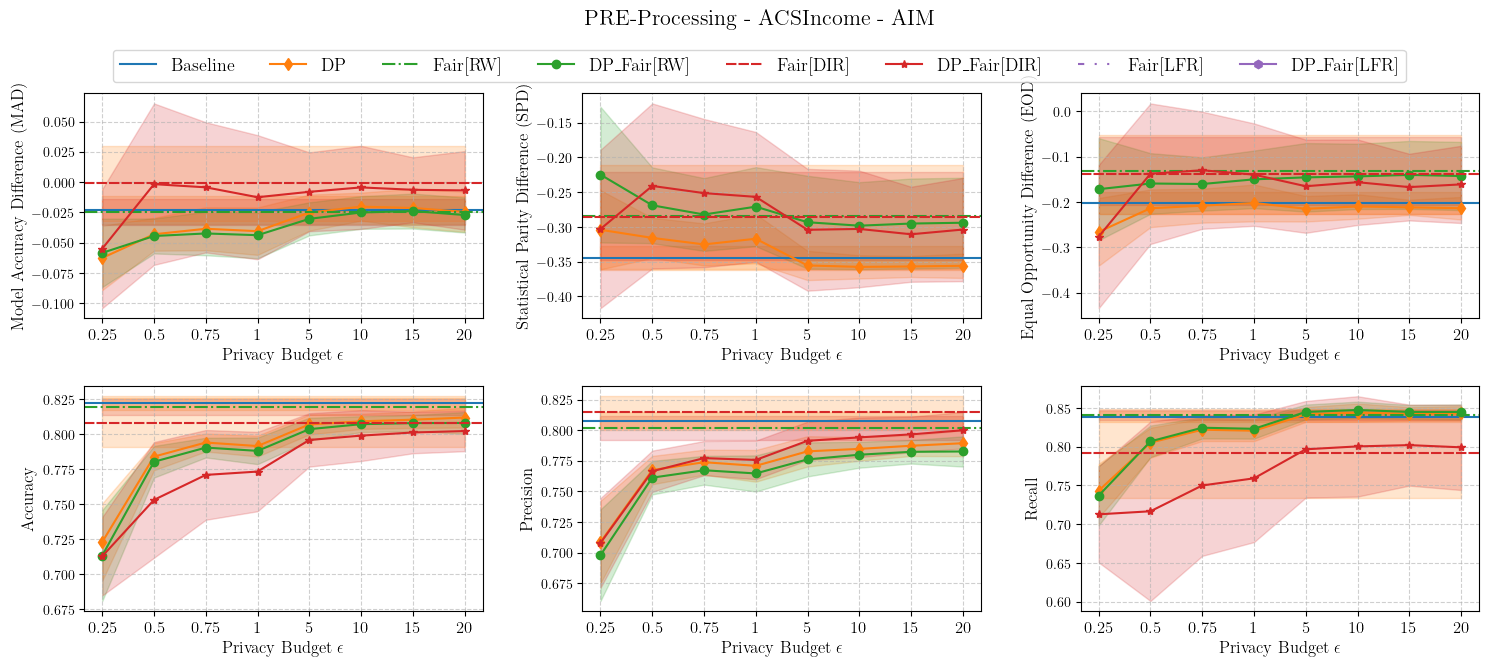

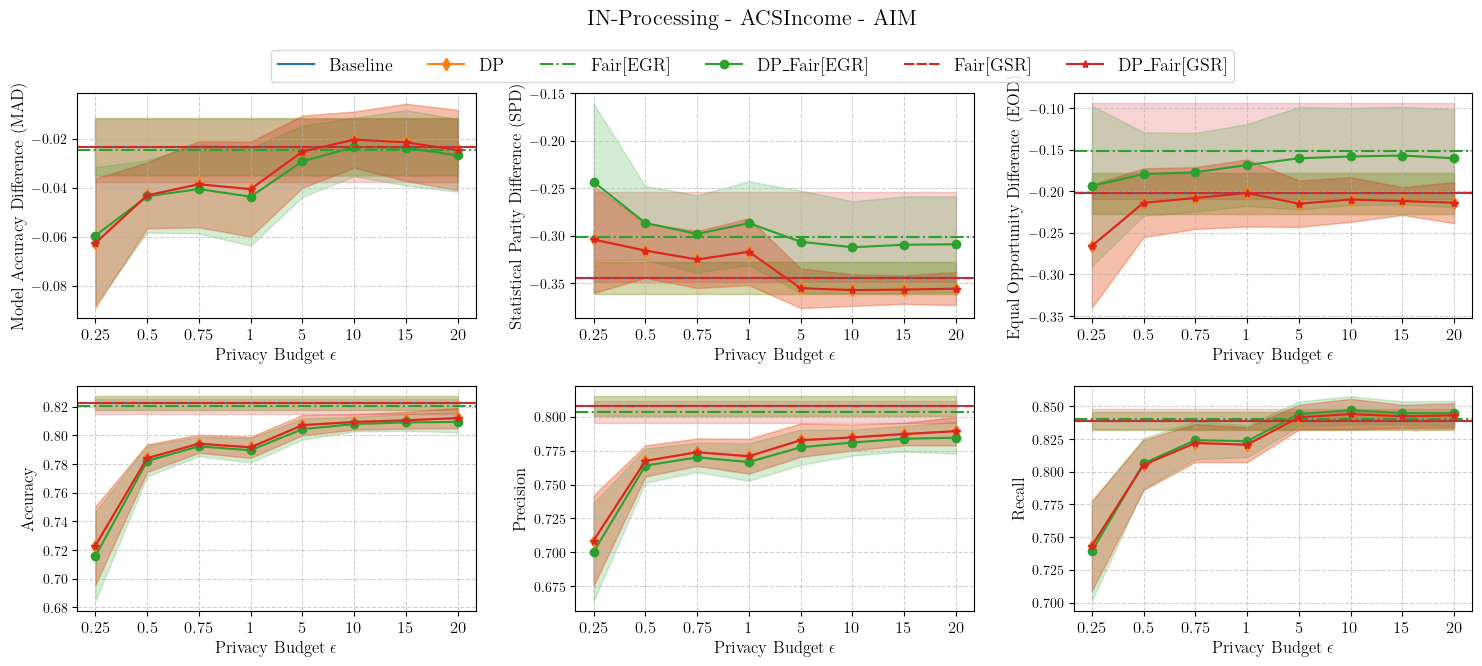

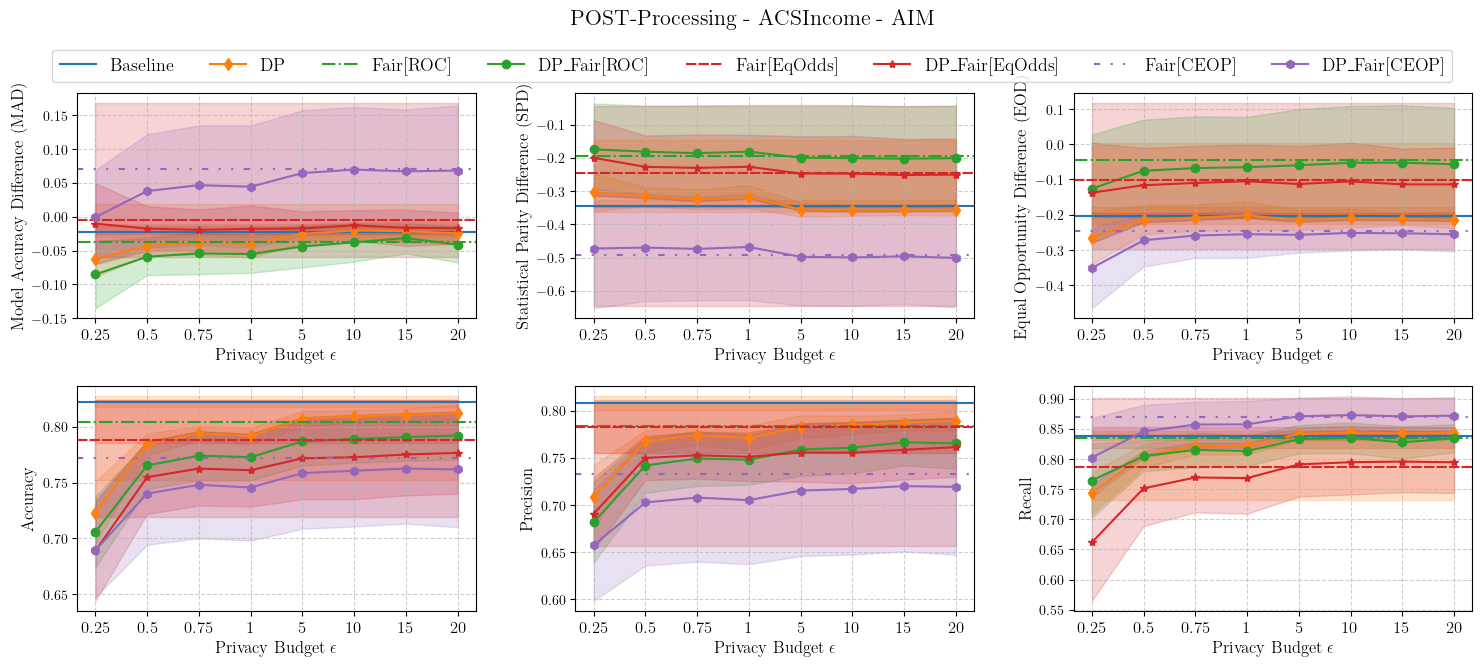

In [ ]:
# Common settings
eps_labels = [0.25, 0.5, 0.75, 1, 5, 10, 15, 20]
eps_positions = list(range(len(eps_labels)))
plot_metrics = ["MAD", "SPD", "EOD", "ACC", "PREC", "REC"]
metric_labels = {
    "ACC": "Accuracy",
    "PREC": "Precision",
    "REC": "Recall",
    "SPD": "Statistical Parity Difference (SPD)",
    "MAD": "Model Accuracy Difference (MAD)",
    "EOD": "Equal Opportunity Difference (EOD)"#"Equalized Odds Difference (EOD)"
}

# Remove rows where any of the specified columns contain "inf" (string or np.inf)
# df_filtered = df_filtered.replace("inf", np.inf)   # convert string "inf" to numeric np.inf
# df_filtered = df_filtered.replace("-inf", -np.inf) # handle negative infinity if present
# df_filtered = df_filtered[~df_filtered[plot_metrics].isin([np.inf, -np.inf]).any(axis=1)]

# Method groups for separate figures
group_defs = {
    f'PRE-Processing - {smart_capitalize(dataset) if dataset != "folktables" else "ACSIncome"}': [
        'Baseline', 'DP',
        'Fair[RW]', 'DP_Fair[RW]',
        'Fair[DIR]', 'DP_Fair[DIR]',
        'Fair[LFR]', 'DP_Fair[LFR]'
    ],
    f'IN-Processing - {smart_capitalize(dataset) if dataset != "folktables" else "ACSIncome"}': [
        'Baseline', 'DP',
        'Fair[EGR]', 'DP_Fair[EGR]',
        'Fair[GSR]', 'DP_Fair[GSR]'
    ],
    f'POST-Processing - {smart_capitalize(dataset) if dataset != "folktables" else "ACSIncome"}': [
        'Baseline', 'DP',
        'Fair[ROC]', 'DP_Fair[ROC]',
        'Fair[EqOdds]', 'DP_Fair[EqOdds]',
        'Fair[CEOP]', 'DP_Fair[CEOP]'
    ]
}

def get_color_index(i):
    if i < 2:
        return i  # 0 for Baseline, 1 for DP
    return (i - 2) // 2 + 2  # Every two steps after index 1 maps to next color

# Simple markers and linestyles for up to 6 methods as we have 6 methods per graph
def make_styles(n):
    base_markers = ['s', 'd', 'X', 'o', 'v', '*', '^', 'h', '+', '_', '0','1','2','3','4','5','6','7','8','9','10','11', 'full', 'left', 'top', 'none', 'right', 'bottom']
    base_linestyles = ['-', '--', '-.', ':', (0, (5, 1)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 10, 1, 10, 1, 10))]
    return base_markers[:n], base_linestyles[:n]

# Loop through each group and produce a 2x3 grid of metrics graphs
for group_name, methods in group_defs.items():
    markers, linestyles = make_styles(len(methods))
    n_colors =  int(len(methods) / 2) + 1
    palette = sns.color_palette("tab10", n_colors)

    fig, axes = plt.subplots(2, 3, figsize=(18, 7))
    fig.suptitle(group_name + ' - ' + extra.replace('_', ' '), fontsize=16, y=0.94)
    plt.subplots_adjust(top=0.85, wspace=0.25, hspace=0.3)

    for idx, metric in enumerate(plot_metrics):
        row, col = divmod(idx, 3)
        ax = axes[row][col]

        for i, method in enumerate(methods):
            method_df = df_filtered[df_filtered["method"] == method].copy()
            method_df["eps_rounded"] = method_df["eps"].round(2)

            # DP-aware (varying epsilon)
            if "DP" in method:
                grouped = method_df.groupby("eps_rounded")[metric].agg(["mean", "std"])
                grouped = grouped.loc[grouped.index.isin(eps_labels)]

                if not grouped.empty:
                    positions = [eps_labels.index(round(eps, 2)) for eps in grouped.index]
                    means = grouped["mean"].values
                    stds = grouped["std"].values

                    ax.plot(
                        positions,
                        means,
                        label=method,
                        marker=markers[i],
                        color=palette[get_color_index(i)]
                    )
                    ax.fill_between(
                        positions,
                        means - stds,
                        means + stds,
                        color=palette[get_color_index(i)],
                        alpha=0.2
                    )

            # Non-DP methods (flat line)
            else:
                mean = method_df[metric].mean()
                std = method_df[metric].std()
                ax.axhline(
                    y=mean,
                    linestyle=linestyles[i],
                    label=method,
                    color=palette[get_color_index(i)]
                )
                ax.fill_between(
                    eps_positions,
                    mean - std,
                    mean + std,
                    color=palette[(i % (int(len(methods)/2)))+1],
                    alpha=0.2
                )

        ax.set_xticks(eps_positions)
        ax.set_xticklabels(eps_labels, fontsize=12)
        ax.set_xlabel(r"Privacy Budget $\epsilon$", fontsize=12)
        ax.set_ylabel(metric_labels[metric], fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)

    fig.suptitle(group_name + f" - {synth.upper()}" + f"{' - ' + extra.replace('_', ' ') if extra else ''}", fontsize=16, y=0.97)

    handles, labels = axes[0][0].get_legend_handles_labels()

    fig.legend(
        handles,
        labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.925),
        ncol=len(methods),
        fontsize=13
    )

    plt.subplots_adjust(top=0.85)


    # Save and show each figure
    out_file = f'results_{synth}_{group_name}{"_"+extra if extra else ""}.pdf'
    plt.savefig(out_file, dpi=900, bbox_inches='tight', pad_inches=0.1)
    plt.show()


# Download all graphs

In [ ]:
from google.colab import files
!mkdir pdf
!mv *.pdf pdf/
!zip pdf.zip pdf/*.pdf
files.download('pdf.zip')

  adding: pdf/results_aim_IN-Processing - ACSIncome.pdf (deflated 4%)
  adding: pdf/results_aim_POST-Processing - ACSIncome.pdf (deflated 4%)
  adding: pdf/results_aim_PRE-Processing - ACSIncome.pdf (deflated 4%)
  adding: pdf/results_mst_IN-Processing - ACSIncome.pdf (deflated 4%)
  adding: pdf/results_mst_POST-Processing - ACSIncome.pdf (deflated 4%)
  adding: pdf/results_mst_PRE-Processing - ACSIncome.pdf (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>